In [1]:
import warnings
warnings.filterwarnings("ignore")

from dateutil.parser import parse 

import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns
import numpy as np
import pandas as pd

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score
from scipy.interpolate import interp1d

In [2]:
monthly_sunspot=pd.read_csv('monthly-sunspots-train.csv')
monthly_sunspot=monthly_sunspot.rename(columns={"Sunspots":"sunspots", "Month":"month"})

In [3]:
monthly_sunspot.shape

(2796, 2)

In [4]:
monthly_sunspot.head(10)

,month,sunspots
0,1749-01,58.0
1,1749-02,62.6
2,1749-03,70.0
3,1749-04,55.7
4,1749-05,85.0
5,1749-06,83.5
6,1749-07,94.8
7,1749-08,66.3
8,1749-09,75.9
9,1749-10,75.5


In [5]:
monthly_sunspot.tail(10)

,month,sunspots
2786,1981-03,135.5
2787,1981-04,156.4
2788,1981-05,127.5
2789,1981-06,90.0
2790,1981-07,143.8
2791,1981-08,158.7
2792,1981-09,167.3
2793,1981-10,162.4
2794,1981-11,137.5
2795,1981-12,150.1


In [6]:
#convert to datetime format
monthly_sunspot['month'] = pd.to_datetime(monthly_sunspot['month'], errors='coerce',infer_datetime_format=True)

In [7]:
monthly_sunspot.tail(10)

,month,sunspots
2786,1981-03-01,135.5
2787,1981-04-01,156.4
2788,1981-05-01,127.5
2789,1981-06-01,90.0
2790,1981-07-01,143.8
2791,1981-08-01,158.7
2792,1981-09-01,167.3
2793,1981-10-01,162.4
2794,1981-11-01,137.5
2795,1981-12-01,150.1


In [8]:
#setting date as index
monthly_sunspot = monthly_sunspot.set_index('month')

In [9]:
monthly_sunspot.head(10)

,sunspots
month,
1749-01-01,58.0
1749-02-01,62.6
1749-03-01,70.0
1749-04-01,55.7
1749-05-01,85.0
1749-06-01,83.5
1749-07-01,94.8
1749-08-01,66.3
1749-09-01,75.9


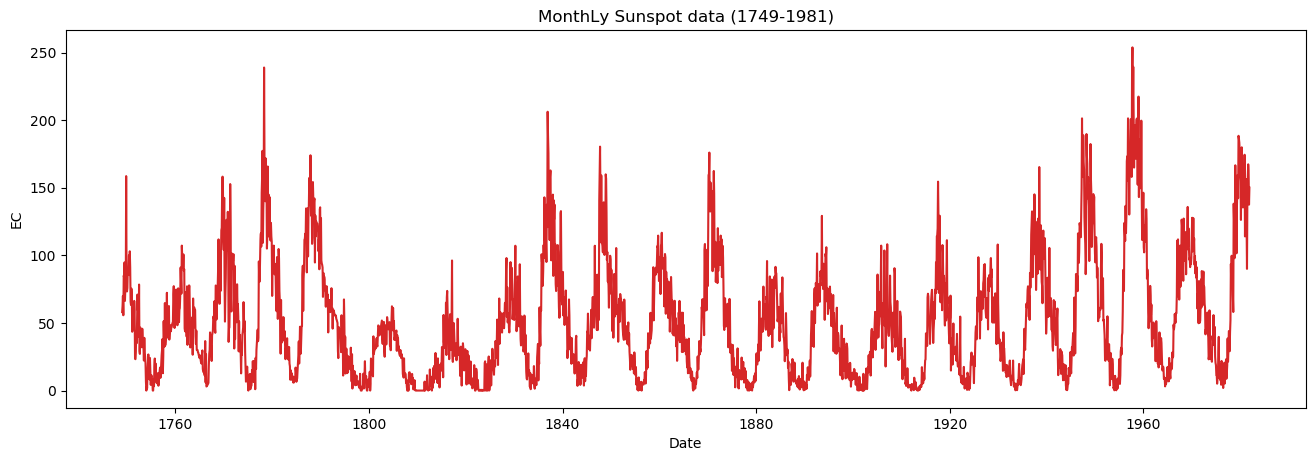

In [10]:
def plot_df(df, x, y, title="", xlabel='Date', ylabel='EC', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()
plot_df(monthly_sunspot, x=monthly_sunspot.index, y=monthly_sunspot.sunspots, title='MonthLy Sunspot data (1749-1981)')  

In [11]:
#The plot shows that it doesn't have any outliers and neither does it have any sudden shift which could have disproportionate effect on it.
# It doesnt have any drastic shift rather a pattern is observed having more peaks with regular cycle. So the seasonality is there. The trend can taken as kind of contant going on straight on horizontal axis.

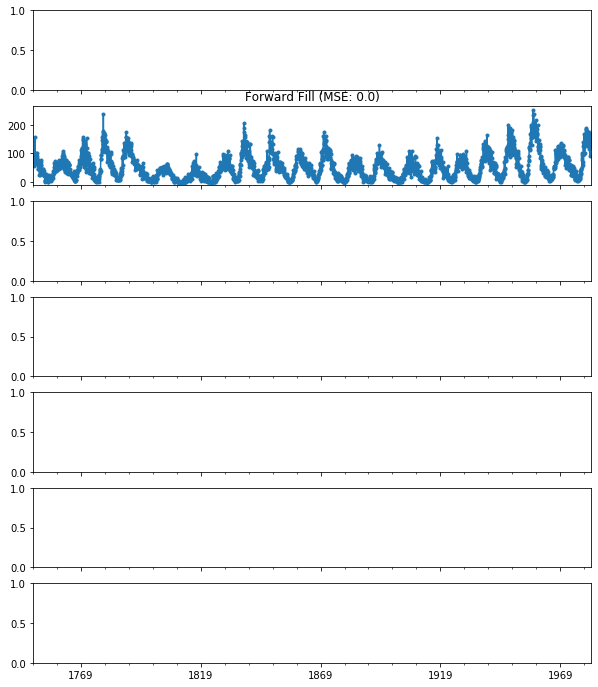

In [12]:
# since the pattern has more peaks with a bit randomness so it seems better to use either backward or forward fill because the mean values from previous or forward data would help. So the pattern is not exactly known.
fig, axes = plt.subplots(7, 1, sharex=True, figsize=(10, 12))
plt.rcParams.update({'xtick.bottom' : False})

df_ffill = monthly_sunspot.ffill()
error = np.round(mean_squared_error(monthly_sunspot['sunspots'], df_ffill['sunspots']), 2)
df_ffill['sunspots'].plot(title='Forward Fill (MSE: ' + str(error) +")", ax=axes[1], label='Forward Fill', style=".-")

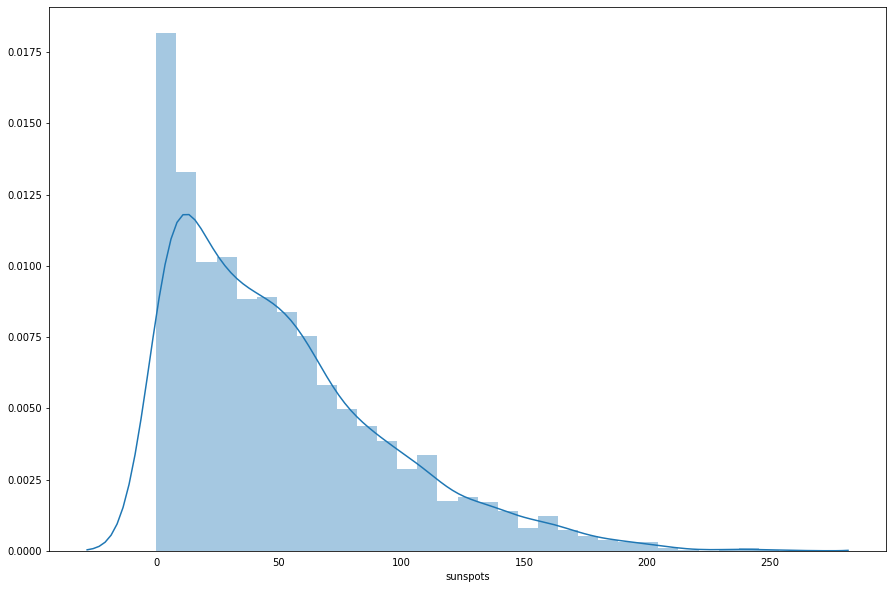

In [13]:
plt.figure(figsize=(15,10))
sns.distplot(monthly_sunspot.sunspots)

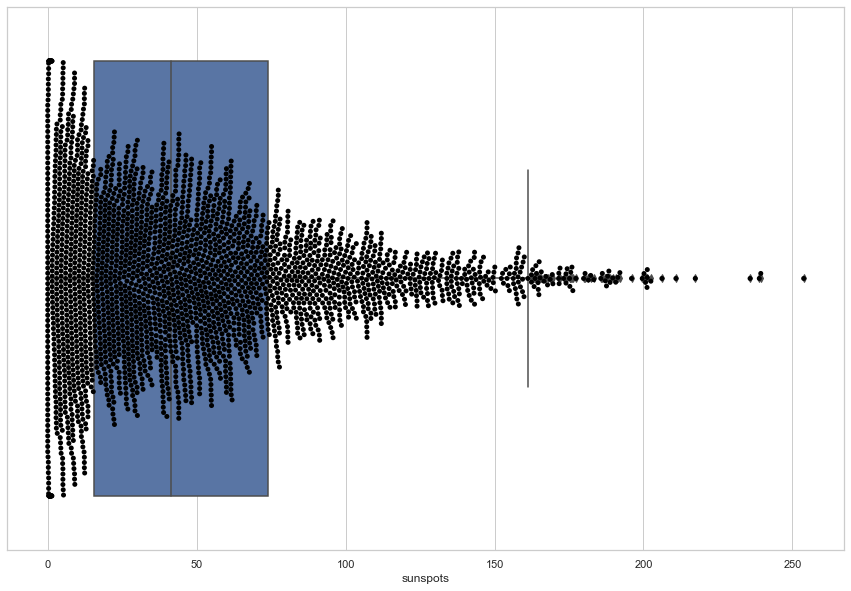

In [14]:
plt.figure(figsize=(15,10))
sns.set(style="whitegrid", color_codes='denim blue')
ax = sns.boxplot(x=monthly_sunspot["sunspots"])
ax = sns.swarmplot(x=monthly_sunspot["sunspots"], color='black')

In [15]:
from statsmodels.tsa.stattools import adfuller
# ADF Test
def dickeyFuller(monthly_sunspot):
    result = adfuller(monthly_sunspot.sunspots.values, autolag='AIC')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    for key, value in result[4].items():
        print('Critial Values:')
        print(f'{key}, {value}')
dickeyFuller(monthly_sunspot)

ADF Statistic: -9.213682599862311
p-value: 1.858365374750531e-15
Critial Values:
1%, -3.4327146584803945
Critial Values:
5%, -2.862584738023912
Critial Values:
10%, -2.5673261469697035


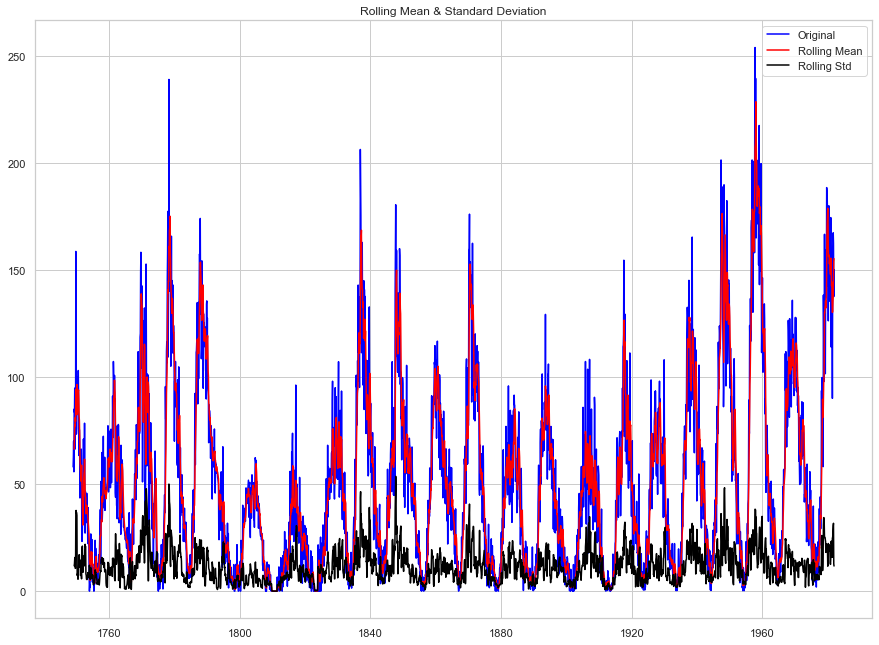

In [16]:
#we can verify this visually also
def rollingGraphs(monthly_sunspot):
    rollavg = monthly_sunspot.rolling(window=5).mean()
    rollstd = monthly_sunspot.rolling(window=5).std()
    plt.figure(figsize=(15,11))
    orig = plt.plot(monthly_sunspot, color='blue', label='Original')
    mean = plt.plot(rollavg, color='red', label='Rolling Mean')
    std = plt.plot(rollstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
rollingGraphs(monthly_sunspot)

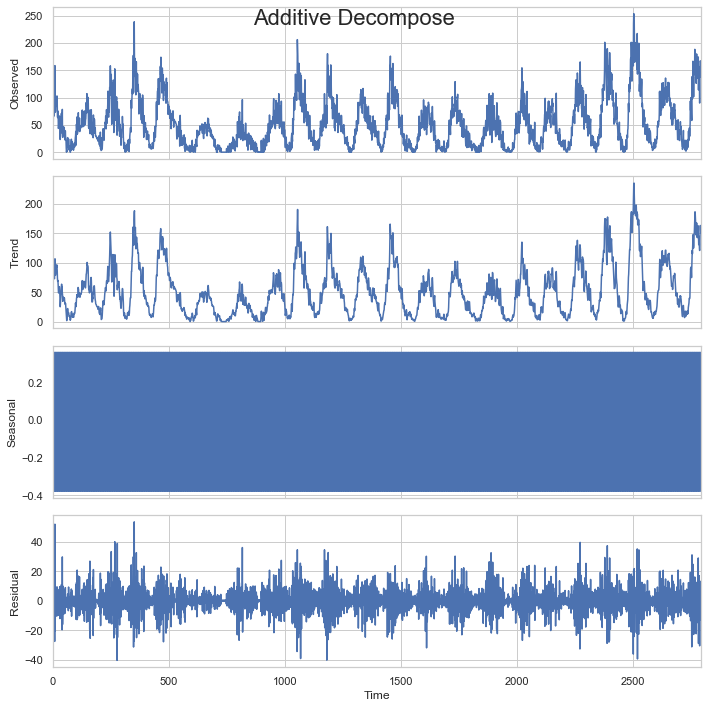

In [17]:
# Additive Decomposition
result_add = seasonal_decompose(np.asarray(monthly_sunspot['sunspots']), model='additive', freq=3, extrapolate_trend='freq')

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
result_add.plot().suptitle('Additive Decompose', fontsize=22)
plt.show()

ADF Statistic: -15.490200135566116
p-value: 2.4905885835493517e-28
Critial Values:
1%, -3.4328512326377636
Critial Values:
5%, -2.86264505301087
Critial Values:
10%, -2.567358258833187


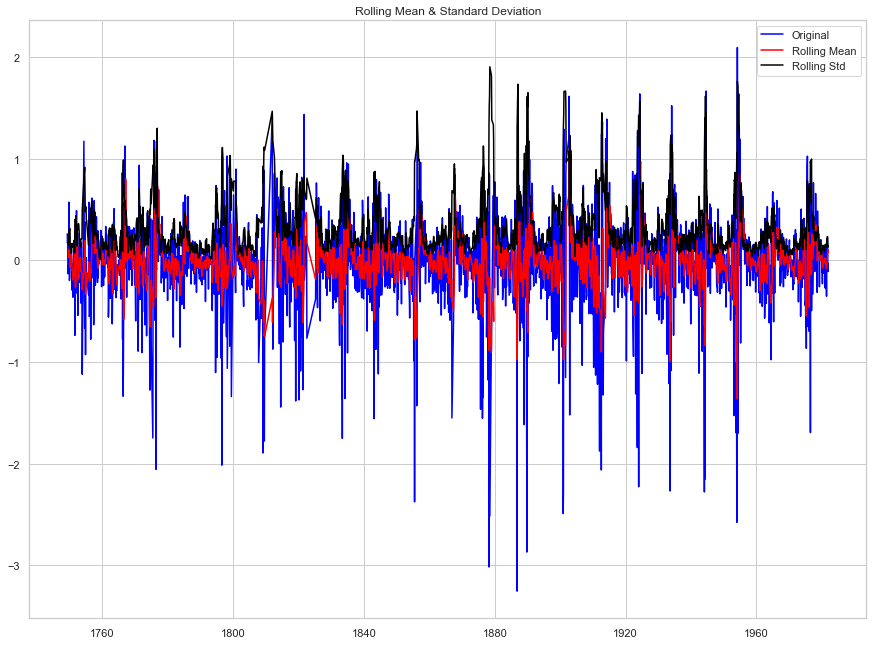

In [18]:
# # log differencing
trainlog = np.log(monthly_sunspot)
rollavgLog = trainlog.rolling(window=5).mean()
differenced = trainlog - rollavgLog
differenced.dropna(inplace=True)
dickeyFuller(differenced)
rollingGraphs(differenced)

In [19]:
#let us select the last 10 observations for testing
monthly_sunspot.shape
train = differenced[:2616]
test = differenced[2616:]
print(train)
print(test)

            sunspots
month               
1749-05-01  0.260984
1749-06-01  0.170299
1749-07-01  0.214221
1749-08-01 -0.132498
1749-09-01 -0.059158
...              ...
1980-10-01  0.098366
1980-11-01  0.003101
1980-12-01  0.118617
1981-01-01 -0.272129
1981-02-01 -0.038934

[2616 rows x 1 columns]
            sunspots
month               
1981-03-01 -0.041817
1981-04-01  0.090452
1981-05-01 -0.051201
1981-06-01 -0.352230
1981-07-01  0.112876
1981-08-01  0.179859
1981-09-01  0.219158
1981-10-01  0.141042
1981-11-01 -0.110159
1981-12-01 -0.031057


In [20]:
# #let us select the last 10 observations for testing
# monthly_sunspot.shape
# train = monthly_sunspot[:2786]
# test = monthly_sunspot[2786:]

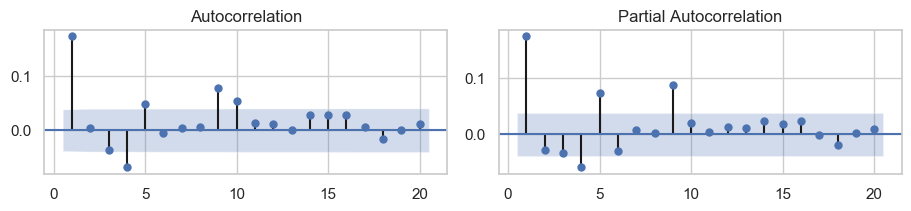

In [21]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(9,2),dpi=100, constrained_layout=True)
plt.plot(figure=plot_acf(train.sunspots.tolist(), lags=20, ax=axes[0], zero=False))
plt.plot(figure=plot_pacf(train.sunspots.tolist(), lags=20, ax=axes[1], zero=False))
plt.show()

c:\users\hr\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


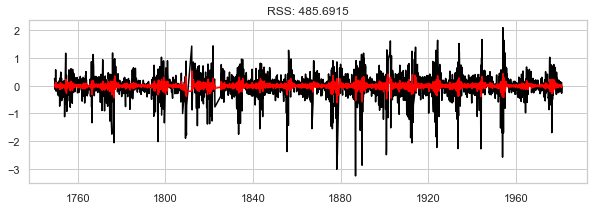

                              ARMA Model Results                              
Dep. Variable:               sunspots   No. Observations:                 2616
Model:                     ARMA(4, 1)   Log Likelihood               -1509.526
Method:                       css-mle   S.D. of innovations              0.431
Date:                Tue, 17 Dec 2019   AIC                           3033.053
Time:                        21:16:53   BIC                           3074.139
Sample:                             0   HQIC                          3047.935
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.0056      0.009     -0.607      0.544      -0.024       0.013
ar.L1.sunspots    -0.5361      0.087     -6.173      0.000      -0.706      -0.366
ar.L2.sunspots     0.1032      0.027

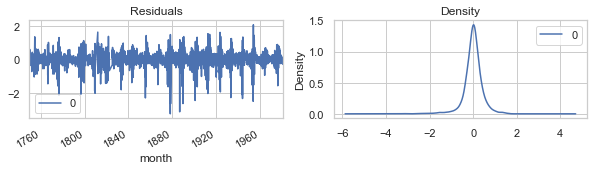

In [22]:
#AR Model (p=1)
model = ARIMA(train, order=(4,0,1))
fittedModel = model.fit(disp=-1)
plt.figure(figsize=(10,3))
plt.plot(train, color='black')
plt.plot(fittedModel.fittedvalues, color='red')
plt.title('RSS: %.4f'%np.sum((fittedModel.fittedvalues - train['sunspots'])**2))
plt.show()
print(fittedModel.summary())

residuals = pd.DataFrame(fittedModel.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0], figsize=(10,2))
residuals.plot(kind='kde', title='Density', ax=ax[1], figsize=(10,2))
plt.show()

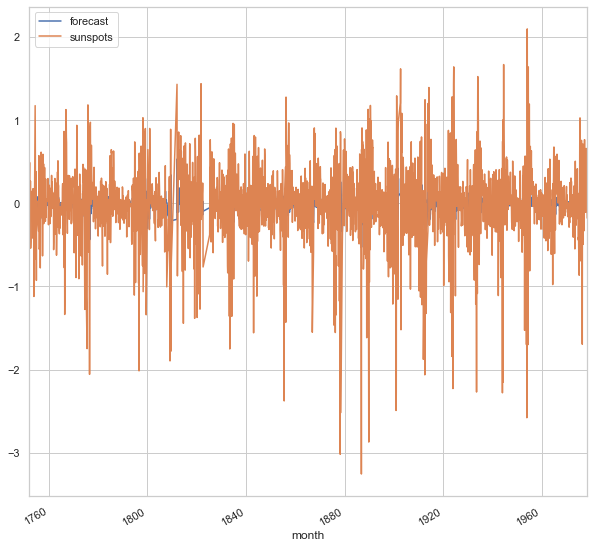

In [23]:
pred = fittedModel.plot_predict(start=pd.to_datetime('1752-01-01'), 
                                end=pd.to_datetime('1978-07-01'), 
                                dynamic=False,
                                plot_insample=True)
plt.show()

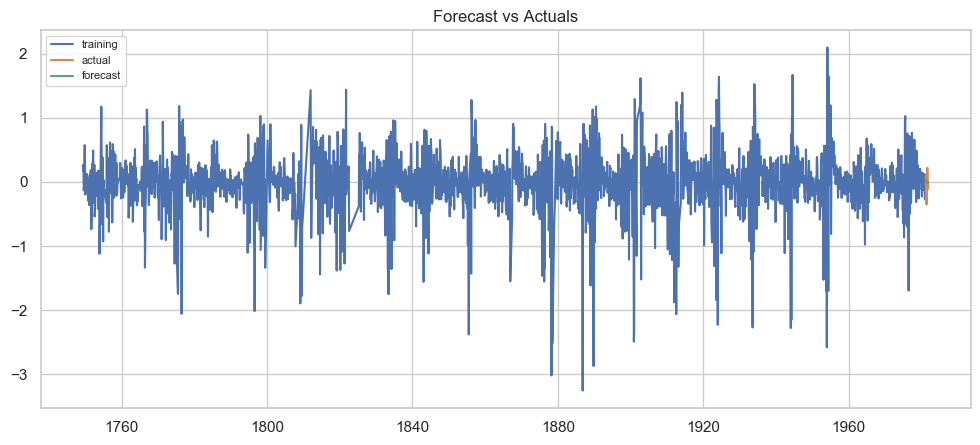

In [24]:
rows,cols=test.shape #shape is 56, means 56 steps

fc, se, conf = fittedModel.forecast(10, alpha=0.05)  # 95% conf

# Make as pandas series
fc = pd.Series(fc, index=test.index)
lower = pd.Series(conf[:, 0], index=test.index)
upper = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test,label='actual')
plt.plot(fc, label='forecast')
# plt.fill_between(lower.index, lower, upper, color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

c:\users\hr\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


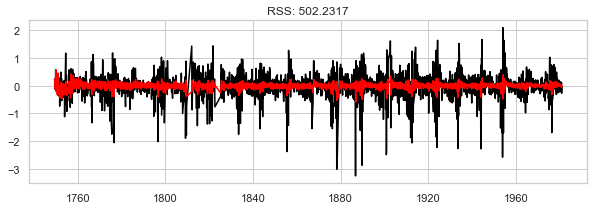

                                 Statespace Model Results                                 
Dep. Variable:                           sunspots   No. Observations:                 2616
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1558.675
Date:                            Tue, 17 Dec 2019   AIC                           3127.350
Time:                                    21:17:21   BIC                           3156.672
Sample:                                         0   HQIC                          3137.973
                                           - 2616                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1737      0.012     14.512      0.000       0.150       0.197
ma.L1         -0.9994      0.015   

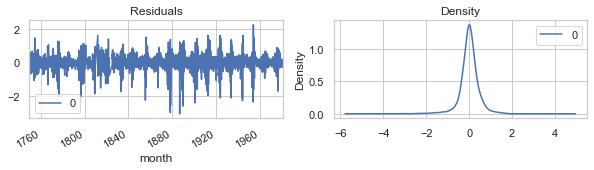

In [25]:

model = SARIMAX(train,order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
fittedModel = model.fit(disp=False)

plt.figure(figsize=(10,3))
plt.plot(train, color='black')
plt.plot(fittedModel.fittedvalues, color='red')
plt.title('RSS: %.4f'%np.sum((fittedModel.fittedvalues - train['sunspots'])**2))
plt.show()
print(fittedModel.summary())

residuals = pd.DataFrame(fittedModel.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0], figsize=(10,2))
residuals.plot(kind='kde', title='Density', ax=ax[1], figsize=(10,2))
plt.show()

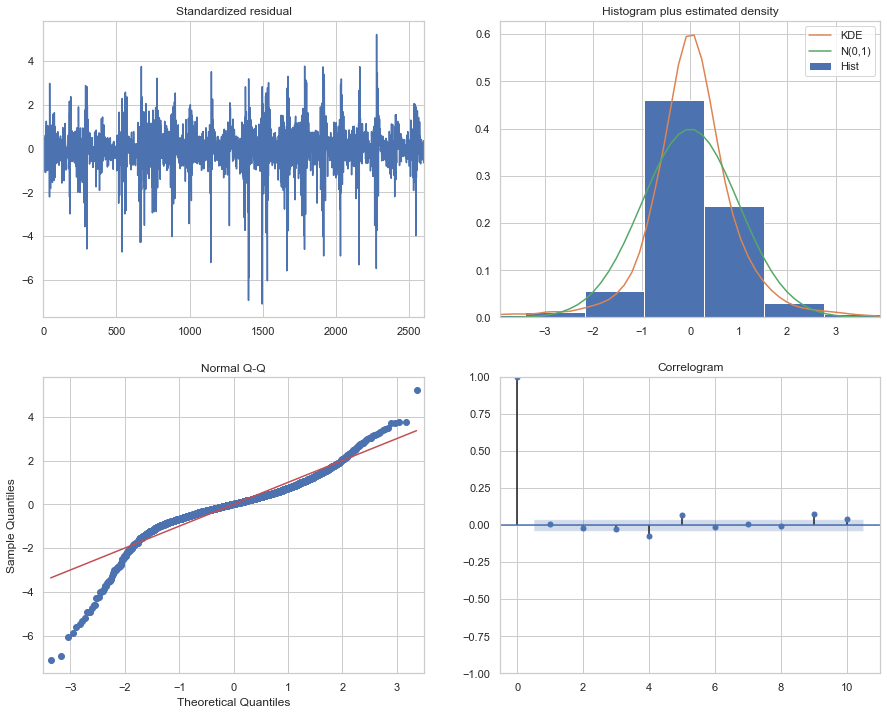

In [26]:
fittedModel.plot_diagnostics(figsize=(15, 12))
plt.show()

In [28]:
pred = fittedModel.get_prediction(start=pd.to_datetime('1752-01-01'), 
                                end=pd.to_datetime('1978-07-01'),dynamic=False)
pred_ci = pred.conf_int()

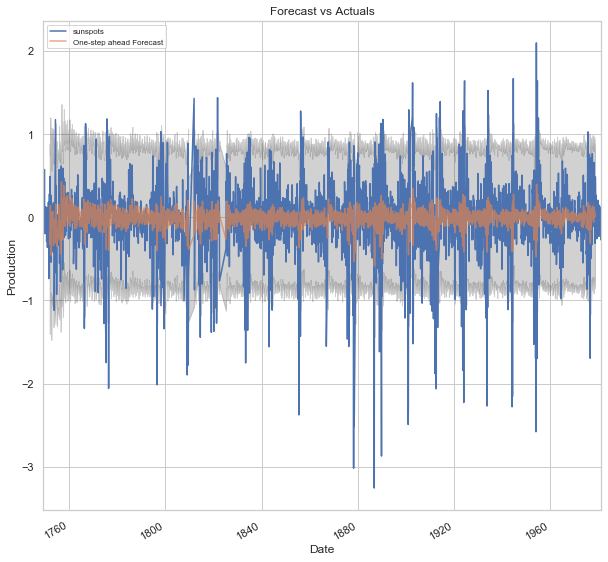

In [29]:
ax = train.plot(label='observed')

pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                 pred_ci.iloc[:, 0],
                 pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Production')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)

plt.show()

In [34]:
y_forecasted = pred.predicted_mean

# Compute the mean square error
mse = ((y_forecasted - train.sunspots) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 0.2


In [35]:
pred_dynamic = fittedModel.get_prediction(start=pd.to_datetime('1752-01-01'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

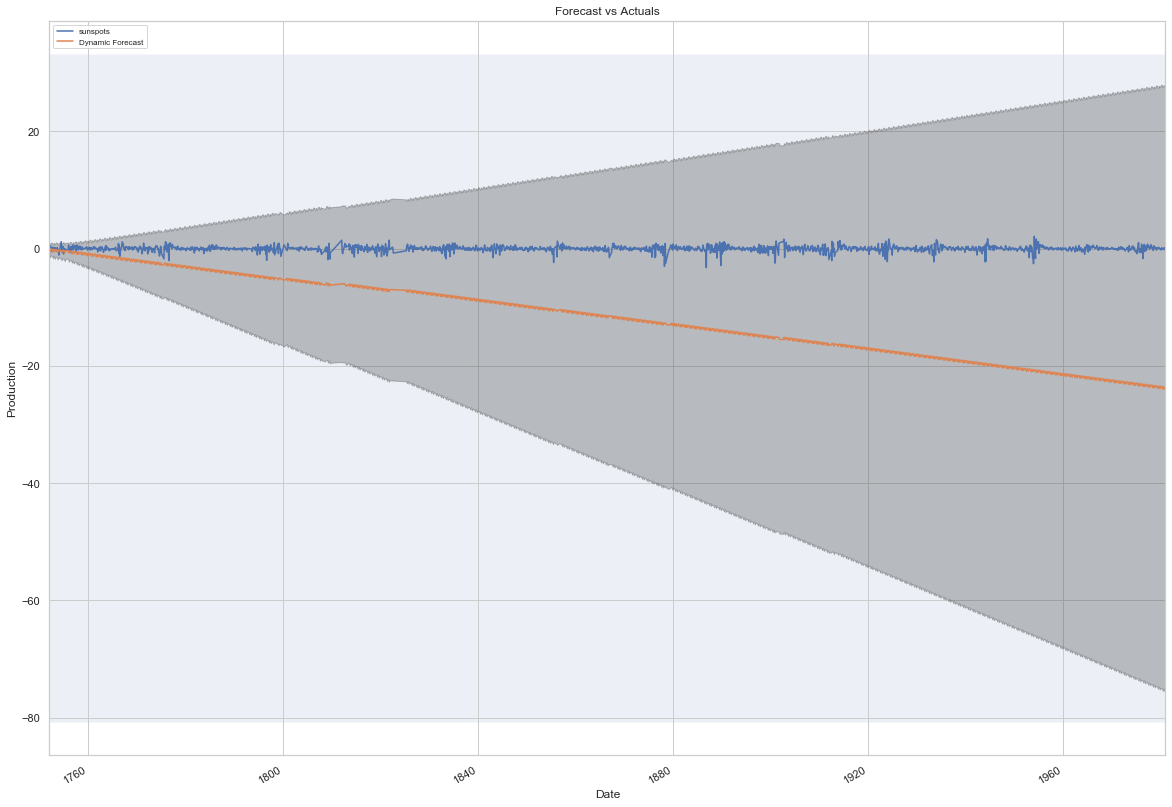

In [44]:
ax = train['1752-01-01':].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('1752-01-01'), train.index[-1],
                 alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Production')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [45]:
y_forecasted = pred.predicted_mean

# Compute the mean square error
mse = ((y_forecasted - train.sunspots) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 0.2


In [50]:
pred_uc = fittedModel.get_forecast(steps=24)
pred_ci = pred_uc.conf_int()
# print(pred_uc)
print(pred_ci)


c:\users\hr\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


      lower sunspots  upper sunspots
2616       -0.853240        0.851426
2617       -0.834501        0.896072
2618       -0.842769        0.888646
2619       -0.875192        0.856260
2620       -0.846476        0.884980
2621       -0.880045        0.851411
2622       -0.859143        0.872314
2623       -0.809103        0.922354
2624       -0.890128        0.841330
2625       -0.908863        0.822595
2626       -0.888333        0.843126
2627       -0.867716        0.863745
2628       -0.858011        0.873670
2629       -0.834151        0.897543
2630       -0.843896        0.887799
2631       -0.875432        0.856265
2632       -0.845222        0.886474
2633       -0.878930        0.852767
2634       -0.859333        0.872365
2635       -0.809588        0.922111
2636       -0.890465        0.841234
2637       -0.910593        0.821106
2638       -0.885795        0.845906
2639       -0.867383        0.864319


In [47]:
ax = train.plot(label='observed', figsize=(20, 15))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Production')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

ValueError: year 0 is out of range

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x000000000A0F6B88> (for post_execute):


ValueError: year 0 is out of range

ValueError: year 0 is out of range

<Figure size 1440x1080 with 1 Axes>